# Tutorial

## Introduction

This is a tutorial to accompany our pre-print: 

Uncovering personalised glucose responses and circadian rhythms from multiple wearable biosensors with Bayesian dynamical modelling (2022) Phillips NE, Collet TH*, Naef F* 

This tutorial presents an Bayesian analysis pipeline for modelling data from multiple wearable devices.

In our study we measured the following variables over a two-week period:

1) Food and drink ingestion events with a smartphone application (MyCircadianClock)
2) Glucose levels with a CGM (FressStyle Libre Pro)
3) Physical activity (Actiheart 5)
4) Heart rate (Actiheart 5)
5) Heart rate variability using RMSSD$^{-1}$ (Actiheart 5)

We subdivide the problem of analysing the multiple signals by creating three successive mathematical models, where the models include different subsets of variables.

- Model 1: ingestion events, CGM, circadian
- Model 2: physical activity, HR, HRV, circadian
- Model 3: ingestion events, CGM, physical activity, HR, HRV, circadian

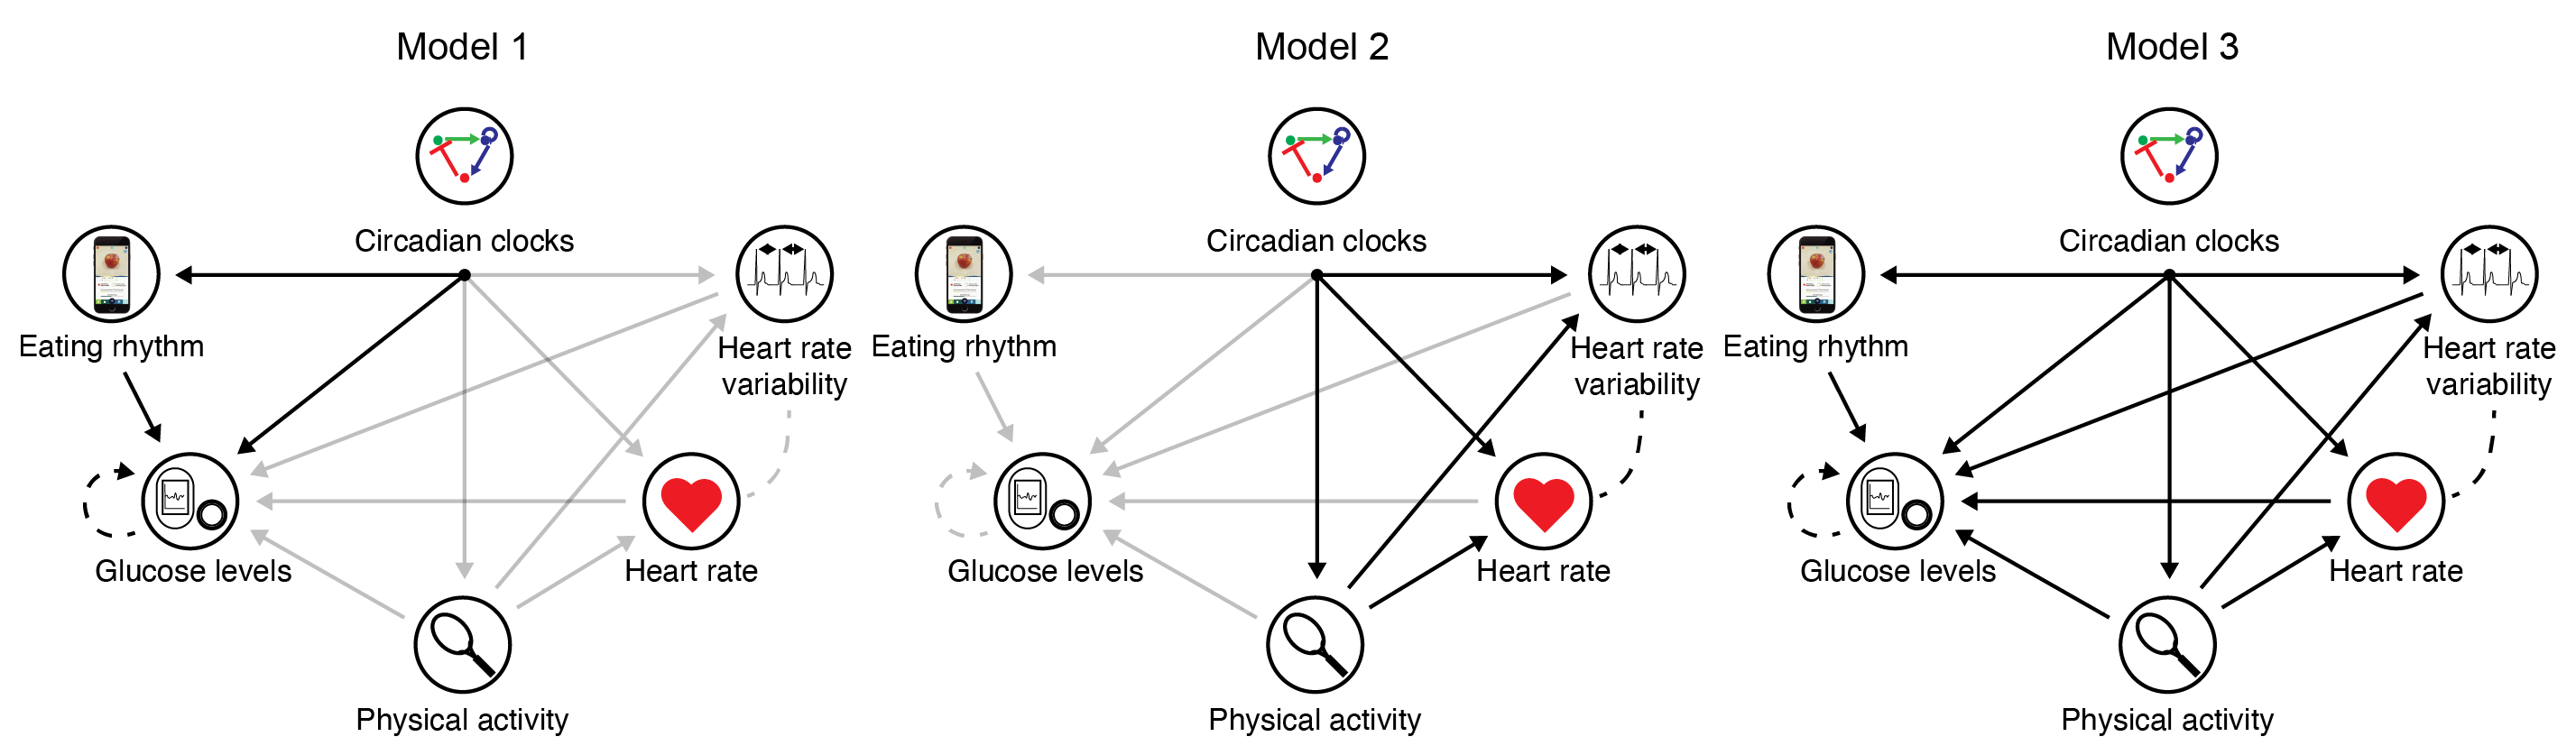

For each of the models, the goal is to quantify the role of external perturbations (such as ingestion events and physical activity) and baseline circadian rhythms on a personalised basis. Parameters are inferred within a Bayesian framework for each individual using MCMC, which provides parameter uncertainties and enables comparison of parameters between participants. 

In this tutorial we will see how to create datasets and perform parameter inference for the three different models.

## Model 1

### Model 1 dataset creation

We'll first create a Model 1 dataset that will subsequently be used as an input into Model 1. We need to provide two files: one file with the meal timestamp information, and another file with the CGM data. The data we will use can be found in the folder `tutorials/tutorial-data`

The meal data also contains another column (labelled 'food_item_index') that assigns a unique index to meals with the same text annotation (meal names have been removed to preserve anonymity).

In [1]:
import os
import dill as pickle
import pandas as pd
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import sys
import tensorflow_probability as tfp
import MSS.config as config
from tensorflow_probability.python import bijectors as tfb
from scipy.stats.stats import pearsonr
from tensorflow_probability import distributions as tfd
from MSS.model1dataset import DatasetModel1SingleSensor
from MSS.model1 import Model1SingleSensor
from MSS.model2dataset import DatasetModel2Actiheart
from MSS.model2 import Model2Actiheart
from MSS.model3dataset import DatasetModel3Integrated
from MSS.model3 import Model3Integrated
os.environ['TF_XLA_FLAGS'] = '--tf_xla_enable_xla_devices'

In [3]:
fname_gluc1 = 'tutorial-data/glucose_MSS16-1.csv'
fname_food1 = 'tutorial-data/food_MSS16-1.xlsx'
data_gluc = DatasetModel1SingleSensor(fname_gluc1,
                                      fname_food1,
                                      study_id='16',
                                      sensor='1')

### Data exploration

Now that we have created a Model 1 dataset, we can perform some basic exploratory data analysis using some of the associated methods.

First of all, let's plot all the glucose CGM time series over all recorded days.

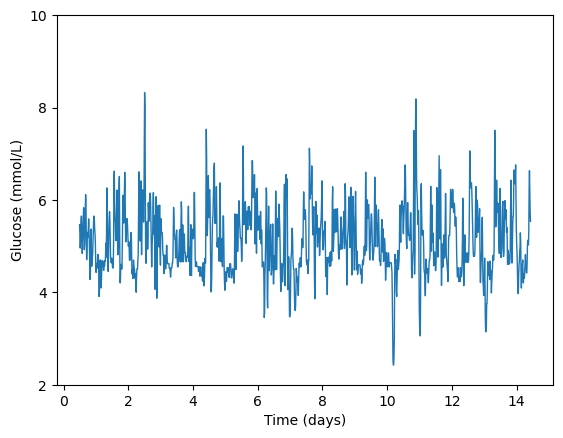

In [4]:
data_gluc.plot_glucose_overview()

We can also check the 24-hour behaviour. The method plot_glucose_circadian() will show all of the glucose data on the same 24-hour clock as different colours, and the mean is shown as a black line.

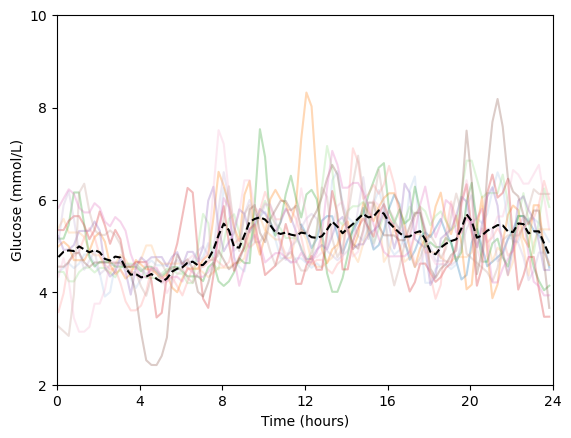

In [5]:
data_gluc.plot_glucose_circadian()  

Finally, we can also check the relationship between meals and glucose by using the plot_gluc_single_day() method to show meals and glucose for a specific day. Meal events are shown as dashed vertical lines.

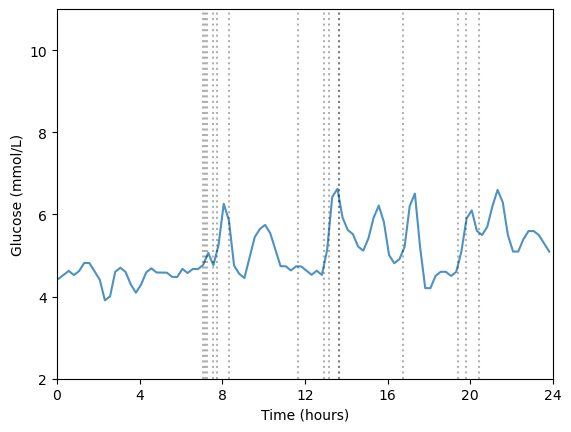

In [6]:
data_gluc.plot_gluc_single_day(day=1)

### Model fitting - finding an initial MAP parameter estimate

We'll now see how to perform parameter inference for Model 1. Firstly, we'll use the Model 1 dataset as an input into a Model 1 class. 

In [7]:
model1 = Model1SingleSensor(data_gluc)

The main results of the paper use MCMC for parameter inference. Before performing MCMC to sample from the model posterior and get parameter uncertainties, we first optimise the model parameters to get a reasonable starting point.

The model has a relatively large number of parameters, and finding the global MAP optimal parameters can be difficult as optimisation can get stuck in local minima. We use the tfp.optimizer.bfgs_minimize function with multiple different initial conditions, where the initial conditions are provided be sampling from the model prior distribution.

The prior can be sampled using .sample_prior() method

In [8]:
sample_vector = model1.sample_prior()

We then optimise model parameters using the .find_MAP() method, where we can set the number of restarts from the random (prior sampled) initial starting points. Set `print_on=True` to see the progression.

In [9]:
model1.find_MAP(model1.get_loss_and_grads_map,N_starts=200,print_on=False)

2022-12-02 09:31:02.660642: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:210] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2022-12-02 09:31:06.824959: I tensorflow/compiler/jit/xla_compilation_cache.cc:363] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


### Checking the model fit

As a basic sanity check, we can plot the model fit and the data. The pearson correlation coefficient between the data and model fit is displayed in the figure title as R.

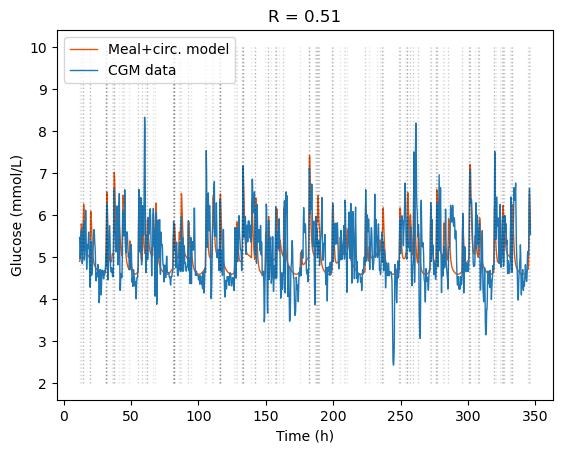

In [10]:
model1.check_meals_glucose_fit(model1.params_opted_map)

### Saving and loading the model

The model can be saved using

In [ ]:
with open('model116_1.pickle', 'wb') as handle:
    pickle.dump(a, handle, protocol=pickle.HIGHEST_PROTOCOL)

The model can be loaded using

In [11]:
with open('tutorial-data/model116_1.pickle', 'rb') as handle:
    model1 = pickle.load(handle) 

Where we have loaded a pre-trained model with MCMC already completed from the `tutorials/tutorial-data` folder.

### Parameter inference with MCMC

While the previous optimation gives point parameter estimates, we'll now use MCMC to sample from the posterior parameter distribution.

We first perform an MCMC "pre-run", where the goal is to obtain a rough estimate of the standard deviation of the posterior parameter distribution. The standard deviation estimate is then used to scale the step size of the MCMC transition kernel for a full run. We then use 4 chains of 10000 samples for the full analysis. As this step takes ~6 hours, we will skip running this step and use the pre-trained model from above. The burn-in for the MCMC is set with `num_burnin_steps`.

In [ ]:
model1.first_MCMC_run(initial_state = model1.params_opted_map,num_burnin_steps = 10000, num_results = 10000)
model1.sample_posterior(initial_state = model1.params_opted_map, num_chains = 4, 
                                    step_size = model1.step_size_optimised, 
                                    num_burnin_steps = 10000, 
                                    num_results = 10000)    

### MCMC diagnostics

The MCMC step saves some metrics than can be used to check that MCMC performed as expected.

1) 'target_log_prob': the log-likelihood of the current parameters. Should be well-mixed                        
2) 'acceptance_rate': the acceptance probability of each chain.
3) 'rhat': the potential scale reduction for chain convergence (Gelman and Rubin (1992))

Let's first just plot the target_log_prob as a quick check to see if mixing seems ok

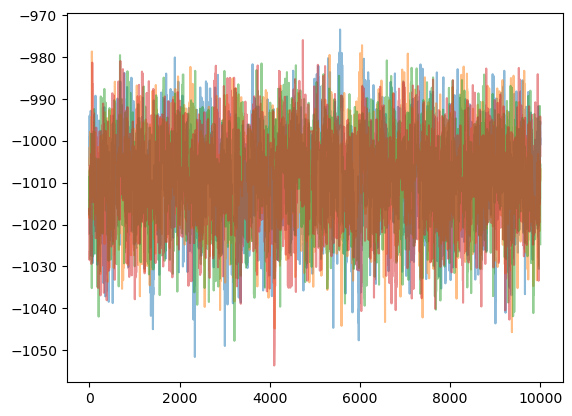

In [12]:
for chain in model1.mcmc_diagnostics['target_log_prob']:
    plt.plot(chain,alpha=0.5)

We can also check that the acceptance probability is in a reasonable range (0.5-0.8) and that it seems about the same between chains

In [13]:
print(model1.mcmc_diagnostics['acceptance_rate'])

[0.5676, 0.5159, 0.6841, 0.7488]


Finally, we can verify the [rhat](https://www.tensorflow.org/probability/api_docs/python/tfp/mcmc/potential_scale_reduction) of the MCMC samples. The rhat values should be close to 1, and sometimes rhat<1.1 is taken as a reasonable threshold

In [14]:
print(model1.mcmc_diagnostics['rhat']) 
print(sum(model1.mcmc_diagnostics['rhat'].numpy()>1.1)) 

tf.Tensor(
[1.0004339  1.0031936  1.0005635  1.0015899  1.0018436  1.0008167
 1.0017121  1.0026186  1.0023034  1.0082055  1.0023668  1.0042446
 1.0028261  1.0005044  1.0057571  1.000075   1.0028657  1.0112981
 1.0068353  1.0004933  1.0046698  1.0151312  1.0070266  1.0020624
 1.0080898  1.0017872  1.0016456  1.0029806  1.0042214  1.0060189
 1.0020841  1.000457   1.0030758  1.0035144  1.0035133  1.0018069
 1.0002658  1.0038034  1.0144147  1.0057939  1.0012753  1.004697
 1.0016849  1.000233   1.002265   1.0107611  1.0003994  1.0208523
 1.0010463  1.0028642  1.0007747  1.003185   1.0004053  1.0011321
 1.0006038  1.001424   1.0059813  1.0003762  1.0051975  1.0002348
 1.0020976  1.0033612  1.0020206  1.005273   1.001079   1.0012639
 1.0005997  1.0020189  1.0014284  1.0003741  1.000302   1.0007739
 1.0024722  1.0031775  1.0005225  1.0022416  1.0007693  1.0007243
 1.0012932  1.0031544  1.0020815  1.0030981  1.0003152  1.002287
 1.0021803  1.0126675  1.0014085  1.0036601  1.0027285  1.004421
 1

### Analysing the output

We can transform the MCMC from an unconstrained space into the constrained space and caluclate some simple metrics such as explained variance with the following two functions

In [ ]:
model1.model_fit_metrics(model1.samples_list)
model1.transform_posterior_params(model1.samples_list)

This creates a dictionary posterior_params_dict, and we can check the variables stored

In [15]:
print(model1.posterior_params_dict.keys())

dict_keys(['A_0', 'A_1', 'phi_1', 'A_11', 'A_12', 'A_21', 'A_22', 'tau', 'B_22', 'sigma', 'meal_heights', 'damping_coeff', 'half_time', 'mean_heights', 'sum_heights'])


We can print the posterior distribution of a particular parameter. Let's plot the posterior distribution of the parameter 'half_time'

Text(0, 0.5, 'Frequency')

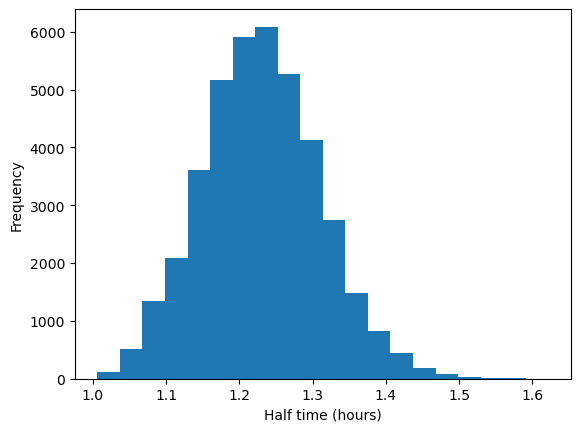

In [16]:
plt.hist(model1.posterior_params_dict['half_time'],bins=20)
plt.xlabel('Half time (hours)')
plt.ylabel('Frequency')

## Model 2

### Model 2 dataset creation

Now we'll turn our attention to Model 2, which models physical activity, heart rate and heart rate variability (expressed as RMSSD$^{-1}$).

First we'll import the Model 2 dataset class.

In [18]:
fname_acti = 'tutorial-data/actiheart_MSS16.csv'
data_acti = DatasetModel2Actiheart(fname_acti)

We can plot single day examples

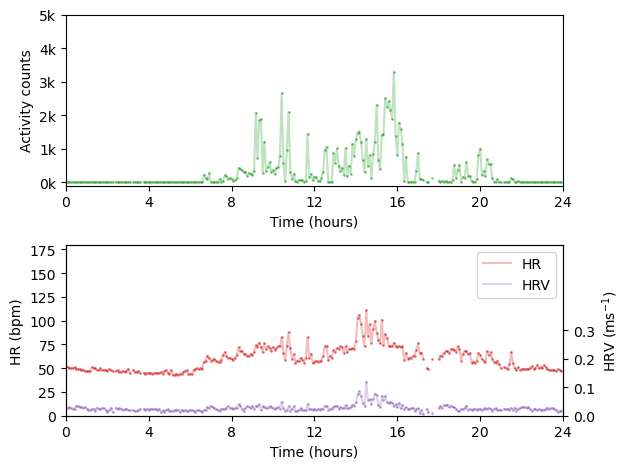

In [19]:
plt.subplot(2,1,1)
data_acti.plot_activity_single_day(day=8)
plt.subplot(2,1,2)
data_acti.plot_heart_single_day(day=8)
plt.tight_layout()

### Model fitting

Using the DatasetModel2Actiheart Model 2 dataset, we can then create a Model 2 and fit it as before.

In [20]:
model2 = Model2Actiheart(data_acti)  

With the model created, we can first find a parameter optimum and then perform MCMC.

In [ ]:
model2.find_MAP(model2.get_loss_and_grads_map,N_starts=400,initial_inverse_hessian_scale = 1e-3,print_on=False)
model2.first_MCMC_run(initial_state = model2.params_opted_map,num_burnin_steps = 10000, num_results = 10000)
model2.sample_posterior(initial_state = model2.params_opted_map, num_chains = 4, step_size = model2.step_size_optimised, num_burnin_steps = 10000, num_results = 10000)    
model2.transform_posterior_params()
model2.model_fit_metrics_hr()
model2.model_fit_metrics_hrv()

We can then perform MCMC diagnostics and plot parameter inference in a similar manner to Model 1.

## Model 3

The final model combines the meal and glucose data with the physical activity, HR and HRV data.

Similarly to Models 1 and 2, a Model 3 dataset is first created before using it as an input into Model 3. The parameters are then optimised and MCMC is performed as before.

For the interactions between physical activity, HR and HRV, we use the parameter inference results from Model 2 and keep these parameters fixed.

In [21]:
with open('tutorial-data/model216.pickle', 'rb') as handle:
    model2 = pickle.load(handle)  
    
samples_list = model2.samples_list
posterior = tf.concat(samples_list,0) 
posterior_mean_actiheart = tf.reduce_mean(posterior,0)

With the Model 2 results loaded, we can create a Model 3 dataset.

In [23]:
fname_all = 'tutorial-data/glucose_actiheart_integrated_MSS16-1.csv'
fname_food = 'tutorial-data/food_integrated_MSS16-1.xlsx'
data_all = DatasetModel3Integrated(fname_all,fname_food,sensor='1')

We can then create a Model 3 object and perform parameter inference.

In [ ]:
model3 = Model3Integrated(data_all,posterior_mean_actiheart)    
model3.find_MAP(model3.get_loss_and_grads_map,N_starts=200)
model3.first_MCMC_run(initial_state = model3.params_opted_map,num_burnin_steps = 100, num_results = 100)
model3.sample_posterior(initial_state = model3.params_opted_map, 
                                num_chains = 4, 
                                step_size = model3.step_size_optimised, 
                                num_burnin_steps = 100, 
                                num_results = 100)    
model3.model_fit_metrics()
model3.transform_posterior_params()